# Introduction to Graph Theory

# What is Graph Theory?

Definition: A field of mathematics studying relationships between objects.

Graph = set of vertices (nodes) + edges (links).

Used in:

Social networks

Transport routes

Web page linking

Supply chain optimization

# Key Terms

#  Real-World Examples

# Using NetworkX for Graphs

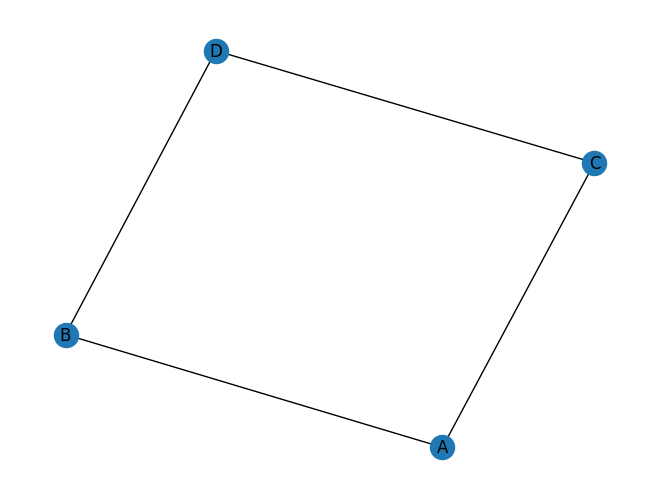

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([("A", "B"), ("A", "C"), ("B", "D"), ("C", "D")])

nx.draw(G, with_labels=True)
plt.show()

# Traversing a Graph

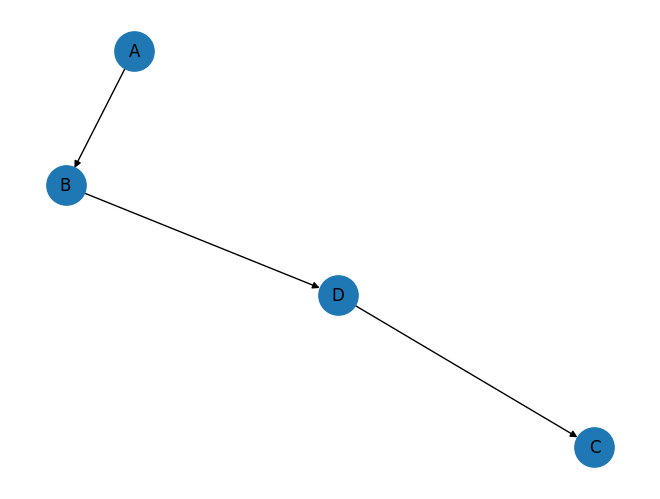

In [2]:
import matplotlib.pyplot as plt

T = nx.dfs_tree(G, source="A")
nx.draw(T, with_labels=True, node_size=800)
plt.show()


# Breadth-First Search (BFS):

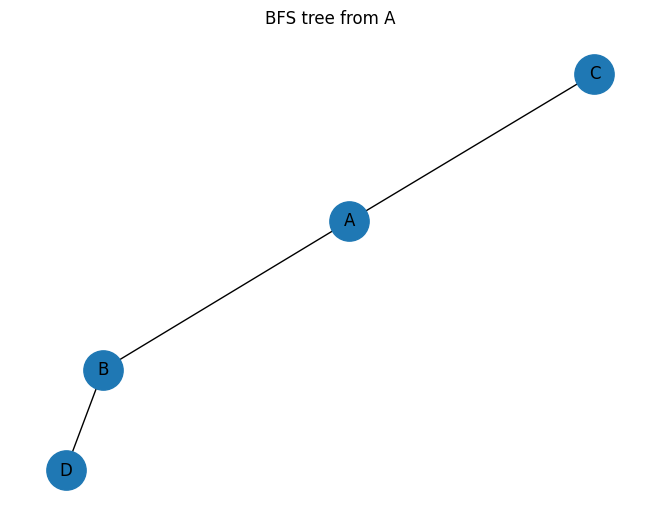

In [3]:
B = nx.bfs_tree(G, source="A")
pos = nx.spring_layout(B)
nx.draw(B, pos, with_labels=True, node_size=800, arrows=False)
plt.title("BFS tree from A")
plt.show()

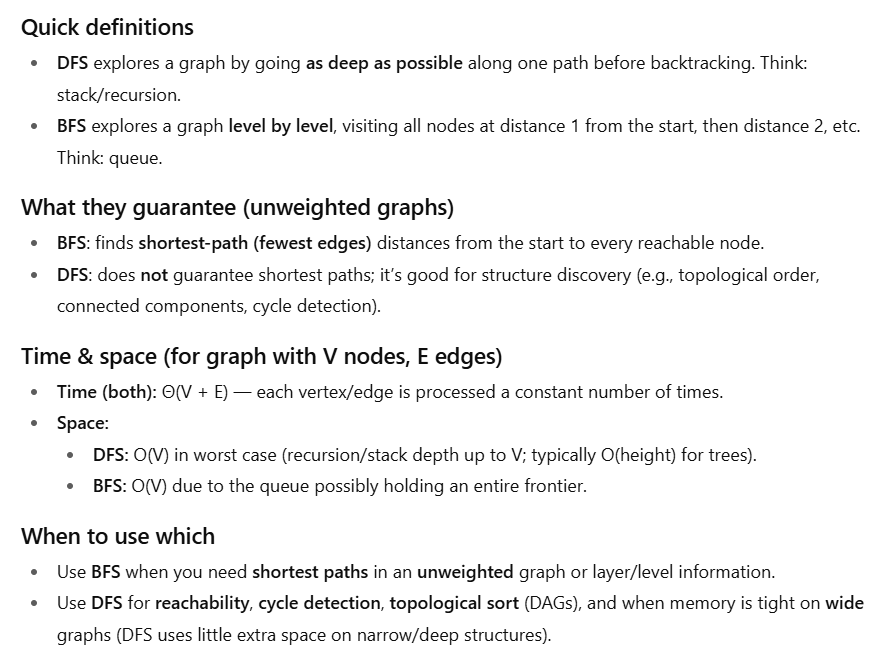

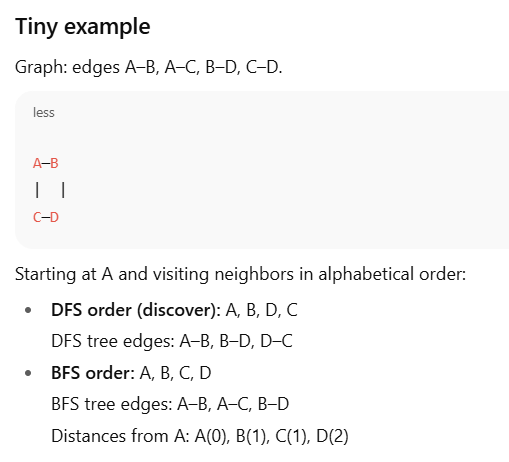

# Shortest Path Example

In [4]:
path = nx.shortest_path(G, source="A", target="D")
print("Shortest path from A to D:", path)

Shortest path from A to D: ['A', 'B', 'D']


# Weighted Graph Example

In [5]:
G = nx.Graph()
G.add_weighted_edges_from([
    ("A", "B", 5),
    ("A", "C", 3),
    ("B", "D", 2),
    ("C", "D", 4)
])
print(nx.shortest_path(G, "A", "D", weight="weight"))


['A', 'B', 'D']


# In-Class Activity

# Routing & Logistics (Shortest Path with costs)

In [6]:
import networkx as nx

G = nx.Graph()
G.add_weighted_edges_from([
    ("Warehouse", "A", 4), ("Warehouse", "B", 2),
    ("A", "C", 5), ("B", "C", 1), ("C", "Store", 3)
])

cost = nx.shortest_path_length(G, "Warehouse", "Store", weight="weight")
route = nx.shortest_path(G, "Warehouse", "Store", weight="weight")
print("Best route:", route, "Total cost:", cost)

Best route: ['Warehouse', 'B', 'C', 'Store'] Total cost: 6


# Find the Influencers” (Centrality in Social Networks)

In [7]:
import networkx as nx

G = nx.Graph()
G.add_edges_from([
    ("Ali","Bea"),("Ali","Chen"),("Bea","Dee"),("Chen","Dee"),
    ("Dee","Eka"),("Eka","Farah"),("Chen","Farah")
])

# Degree and betweenness centrality
deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G)

print("Top by degree:", max(deg, key=deg.get), round(max(deg.values()),3))
print("Top by betweenness:", max(btw, key=btw.get), round(max(btw.values()),3))

Top by degree: Chen 0.6
Top by betweenness: Dee 0.333


# Ranking Websites/Pages (PageRank)

In [8]:
import networkx as nx

web = nx.DiGraph()
web.add_edges_from([
    ("Home","Products"),("Products","Checkout"),("Blog","Products"),
    ("Home","Blog"),("Blog","Home"),("Products","Blog"),("About","Home")
])

pr = nx.pagerank(web, alpha=0.85)
print("Top pages by PageRank:", sorted(pr.items(), key=lambda x: -x[1]))

Top pages by PageRank: [('Products', 0.2702687786388718), ('Blog', 0.2702687786388718), ('Home', 0.22525600167696247), ('Checkout', 0.17453550757545708), ('About', 0.05967093346983711)]


## Real word Example


1) Air Transport Network (OpenFlights) — hubs & routes
Downloaded: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat -> graph_data/airports.dat


Downloaded: https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat -> graph_data/routes.dat


Airports (nodes): 7,697, Routes (edges): 37,042

Top 10 airports by outgoing routes:
   FRA  out= 239  Frankfurt am Main Airport — Germany
   CDG  out= 237  Charles de Gaulle International Airport — France
   AMS  out= 232  Amsterdam Airport Schiphol — Netherlands
   IST  out= 226  Istanbul Airport — Turkey
   ATL  out= 217  Hartsfield Jackson Atlanta International Airport — United States
   ORD  out= 206  Chicago O'Hare International Airport — United States
   PEK  out= 204  Beijing Capital International Airport — China
   MUC  out= 191  Munich Airport — Germany
   DME  out= 188  Domodedovo International Airport — Russia
   DXB  out= 187  Dubai International Airport — United Arab Emirates

Shortest (fewest hops) route KUL->JFK (2 hops):
KUL -> AUH -> JFK


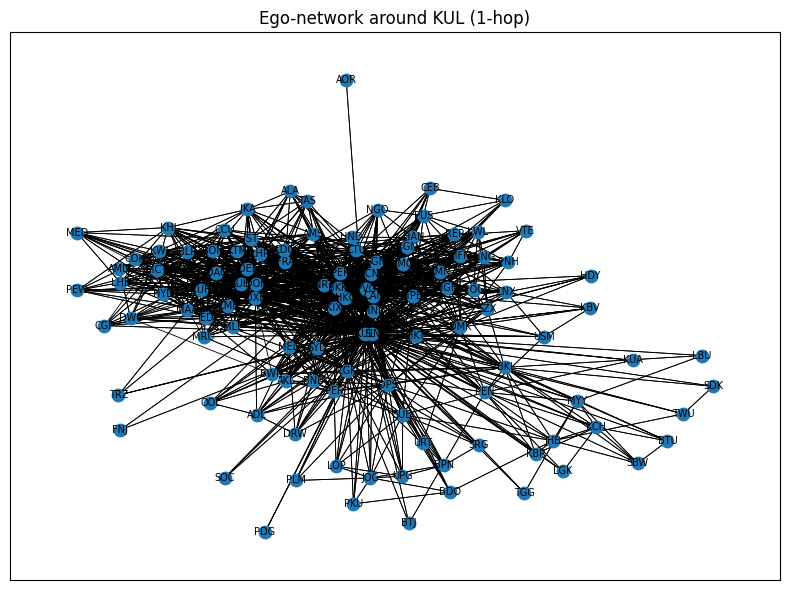

In [9]:
# -*- coding: utf-8 -*-
"""
Three real-world graph theory examples with live datasets:
1) Airline route network (OpenFlights) -> hubs, shortest paths (KUL->JFK)

Requires: pandas, numpy, networkx, matplotlib, requests
> pip install pandas numpy networkx matplotlib requests
"""

from __future__ import annotations
import io
import gzip
import math
import textwrap
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("graph_data")
DATA.mkdir(exist_ok=True)

# -----------------------------
# Utilities
# -----------------------------
def fetch(url: str, path: Path) -> Path:
    """Download a file if missing; return local path."""
    if not path.exists():
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        path.write_bytes(r.content)
        print(f"Downloaded: {url} -> {path}")
    return path

def print_banner(title: str):
    print("\n" + "="*80)
    print(title)
    print("="*80)

# -----------------------------
# 1) AIR TRANSPORT NETWORK — OpenFlights (Directed)
#    Data: airports.dat, routes.dat
# -----------------------------
def air_transport_example():
    print_banner("1) Air Transport Network (OpenFlights) — hubs & routes")
    # Sources:
    # airports.dat, routes.dat from OpenFlights (public mirror on GitHub)
    # URLs documented at https://openflights.org/data  (see GitHub data files)
    url_airports = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
    url_routes   = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

    p_airports = fetch(url_airports, DATA/"airports.dat")
    p_routes   = fetch(url_routes,   DATA/"routes.dat")

    # According to OpenFlights schema:
    # airports.dat columns:
    cols_airports = [
        "AirportID","Name","City","Country","IATA","ICAO","Latitude","Longitude",
        "Altitude","Timezone","DST","TzDatabaseTimeZone","Type","Source"
    ]
    airports = pd.read_csv(
        p_airports, header=None, names=cols_airports,
        na_values="\\N", encoding="utf-8"
    )
    # routes.dat columns:
    cols_routes = [
        "Airline","AirlineID","SourceAirport","SourceAirportID",
        "DestinationAirport","DestinationAirportID","Codeshare","Stops","Equipment"
    ]
    routes = pd.read_csv(
        p_routes, header=None, names=cols_routes,
        na_values="\\N", encoding="utf-8"
    )

    # Build directed multigraph of routes between airports by IATA (fallback to ICAO if IATA missing)
    def pick_code(row):
        return row["IATA"] if pd.notna(row["IATA"]) and row["IATA"] != "" else row["ICAO"]
    airports["Code"] = airports.apply(pick_code, axis=1)
    airports = airports.dropna(subset=["Code"])

    # Map code -> (name,country,lat,lon)
    meta = airports.set_index("Code")[["Name","Country","Latitude","Longitude"]].to_dict("index")

    # Keep only routes where both endpoints have a code we recognize
    edges = []
    for _, r in routes.iterrows():
        src, dst = r["SourceAirport"], r["DestinationAirport"]
        if isinstance(src, str) and isinstance(dst, str) and src in meta and dst in meta:
            edges.append((src, dst))

    G = nx.DiGraph()
    for code, info in meta.items():
        G.add_node(code, **info)
    G.add_edges_from(edges)

    print(f"Airports (nodes): {G.number_of_nodes():,}, Routes (edges): {G.number_of_edges():,}")

    # Degree centrality (in-/out-degree) to find hubs
    deg_out = dict(G.out_degree())
    deg_in  = dict(G.in_degree())
    def topk(d, k=10):
        return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

    print("\nTop 10 airports by outgoing routes:")
    for code, d in topk(deg_out):
        i = G.nodes[code]
        print(f"  {code:>4}  out={d:4d}  {i.get('Name','')} — {i.get('Country','')}")

    # Shortest path by hops from Kuala Lumpur (KUL) to New York JFK
    src_code, dst_code = "KUL", "JFK"
    if src_code in G and dst_code in G:
        try:
            sp = nx.shortest_path(G, source=src_code, target=dst_code)
            print(f"\nShortest (fewest hops) route {src_code}->{dst_code} ({len(sp)-1} hops):")
            print(" -> ".join(sp))
        except nx.NetworkXNoPath:
            print(f"No path found from {src_code} to {dst_code}.")
    else:
        print("KUL or JFK not present in current graph index.")

    # Quick visualization of the local ego-network around KUL
    try:
        center = "KUL"
        H = nx.ego_graph(G, center, radius=1, undirected=False)  # center and its neighbors
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(H, seed=7)
        nx.draw_networkx_nodes(H, pos, node_size=80)
        nx.draw_networkx_edges(H, pos, arrows=False, width=0.6)
        nx.draw_networkx_labels(H, pos, font_size=7)
        plt.title("Ego-network around KUL (1-hop)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    air_transport_example()

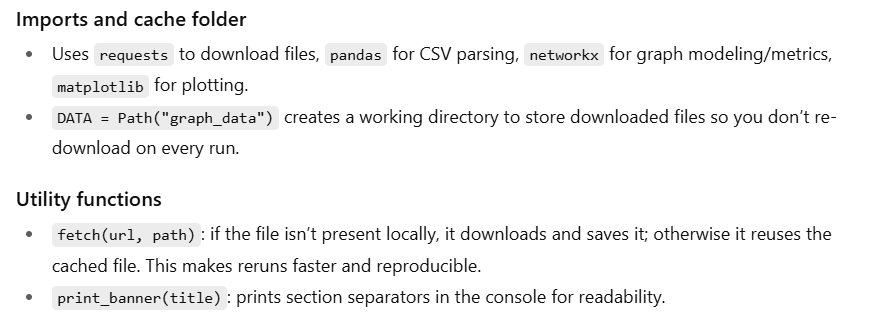

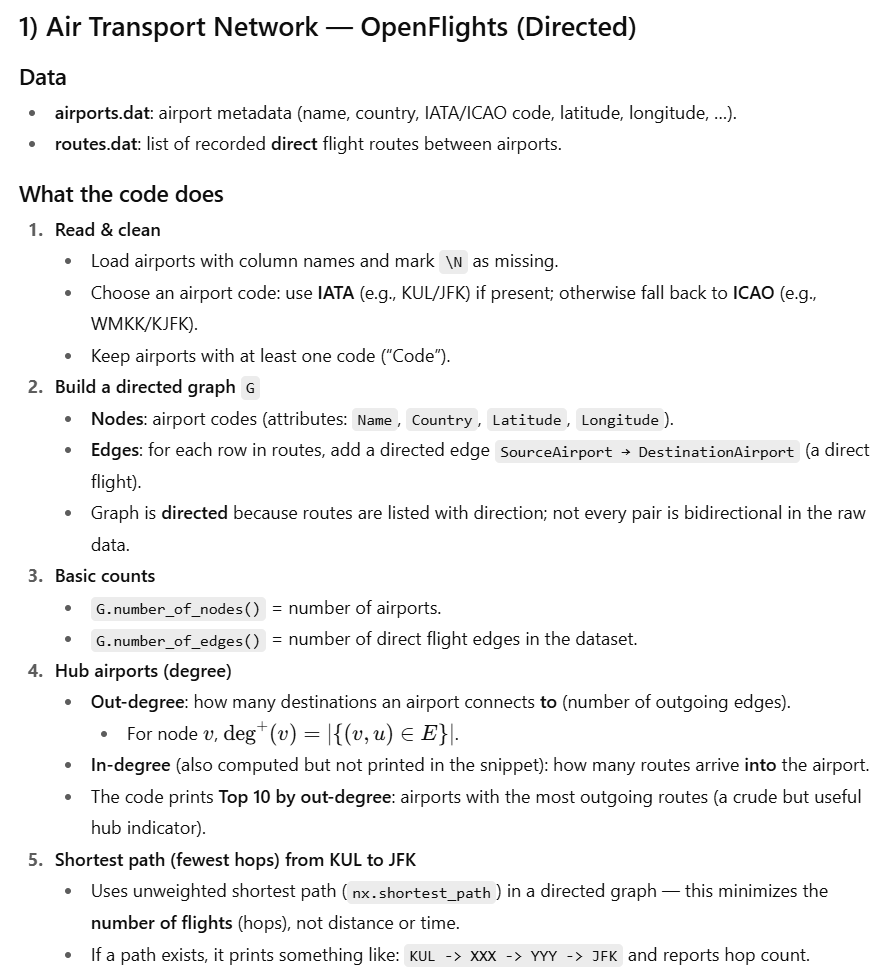

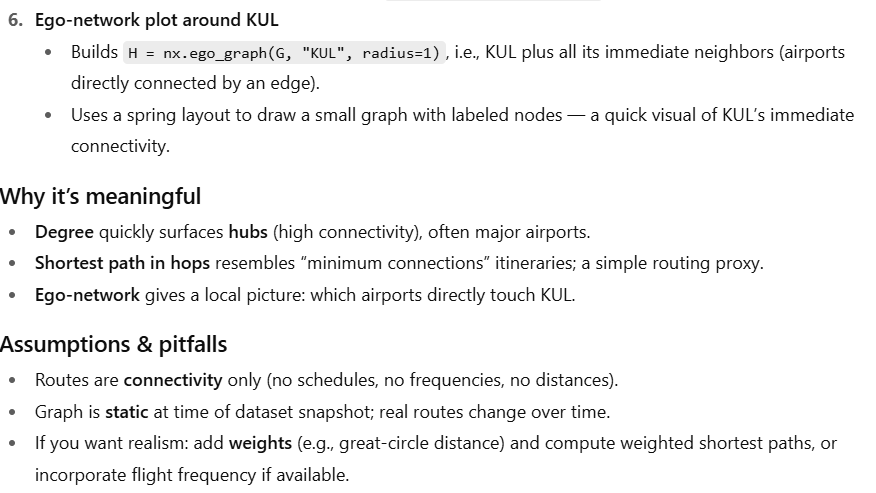

# Key Takeaways

# Homework